# Reproducing previous Machine-learning paper

ddd

In [1]:
import os
import sys
from pathlib import Path
import functools

import pandas
import numpy

import matplotlib
import matplotlib.pyplot

In [2]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
root_repo_dir = Path().absolute().parent
sys.path = [os.path.join(root_repo_dir,'dataexploration'),
            os.path.join(root_repo_dir,'classification'),
            os.path.join(root_repo_dir,'preprocessing'),
            os.path.join(root_repo_dir,'metrics'),
           ] + sys.path

In [5]:
from xbt_dataset import XbtDataset

In [6]:
from imeta import imeta_classification, XBT_MAX_DEPTH

In [7]:
# Set up some site specific parameters for the notebook
environment = 'pangeo'
env_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/annual_csv',
    'pangeo': '/data/misc/xbt-data/annual_csv/',
}
env_date_ranges = {
    'MO_scitools': (1996,2015),
    'pangeo': (1966,2015)
}

In [8]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year']

In [9]:
xbt_full_dataset = XbtDataset(env_data_dirs[environment], env_date_ranges[environment])

In [10]:
xbt_labelled = xbt_full_dataset.filter_obs('labelled', 'labelled')

extracting labelled


In [12]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)


In [13]:
imeta_model = imeta_classes.apply(lambda t1: t1[0]).astype('category', catergories=xbt_labelled['model'].cat.categories)
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1]).astype('category', catergories=xbt_labelled['manufacturer'].cat.categories)

In [14]:
def classify_subset(classifier_class, xbt_subset, x_features, y_feature):
    (ml_ds, ml_encoders) = xbt_subset.filter_features(x_features).get_ml_dataset()
    (ml_target, target_encoders) = xbt_subset.filter_features([y_feature]).get_ml_dataset()
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(ml_ds, ml_target)
    clf_mlp1 = classifier_class()
    clf_mlp1.fit(X_train, y_train)
    y_res_train = clf_mlp1.predict(X_train)
    metric_train = sklearn.metrics.precision_recall_fscore_support(y_train, y_res_train)
    y_res_test = clf_mlp1.predict(X_test)
    metric_test = sklearn.metrics.precision_recall_fscore_support(y_test, y_res_test)
    return {'classifier':clf_mlp1,'metrics_train': metric_train, 'metrics_test': metric_test}

In [15]:
classify_nnet = functools.partial(classify_subset, sklearn.neural_network.MLPClassifier)

In [16]:
results_model1 = {}
results_manufacturer1 = {}

In [17]:
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):
    xbt_subset = xbt_labelled.filter_obs('year', year)
    try:
        results_model1[year] = classify_nnet(xbt_subset, input_feature_names, 'model')
    except Exception as e1:
        print(f'Error processing model {year} - {e1}')
    try:
        results_manufacturer1[year] = classify_nnet(xbt_subset, input_feature_names, 'manufacturer')
    except Exception as e1:
        print(f'Error processing manufacturer {year} - {e1}')


Error processing model 2015 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.
Error processing manufacturer 2015 - Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.


In [18]:
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]+1):

    xbt_subset = xbt_labelled.filter_obs('year',year)
    xbt_model1, enc_model1 = xbt_subset.filter_features(['model']).get_ml_dataset()
    enc_model1 = enc_model1[0]
    xbt_manufacturer1, enc_manuf1 = xbt_subset.filter_features(['manufacturer']).get_ml_dataset()
    enc_manuf1 = enc_manuf1[0]
    
    imeta_output = xbt_subset.xbt_df.apply(lambda x: imeta_classification(x), axis=1)
    imeta_model1 = enc_model1.transform(pandas.DataFrame({'imeta_model':imeta_output.apply(lambda x: x[0])}))
    imeta_manuf1 = enc_manuf1.transform(pandas.DataFrame({'imeta_manufacturer':imeta_output.apply(lambda x: x[1])}))
    
    if enc_model1.categories_[0].shape[0] == 1:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_model, im_rec_model, im_f1_model, im_sup_model) = sklearn.metrics.precision_recall_fscore_support(xbt_model1, imeta_model1,average='macro')
    if enc_manuf1.categories_[0].shape[0] == 1:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = (1.0, 1.0, 1.0, xbt_subset.shape[0])
    else:
        (im_pr_manuf, im_rec_manuf, im_f1_manuf, im_sup_manuf) = sklearn.metrics.precision_recall_fscore_support(xbt_manufacturer1, imeta_manuf1,average='macro')

    imeta_results += [{'year': year,
                       'imeta_model_recall': im_rec_model,
                       'imeta_model_precision': im_pr_model,
                       'imeta_manuf_recall': im_rec_manuf,
                       'imeta_manuf_precision': im_pr_manuf,
                       
                      }]

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [19]:
imeta_res_df = pandas.DataFrame.from_records(imeta_results)

In [20]:
res_manuf_df = pandas.DataFrame({
'year' :list( results_manufacturer1.keys()),
'recall_manuf_train_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_train'][1])
    * numpy.array(results_manufacturer1[year1]['metrics_train'][3])) 
    / sum(results_manufacturer1[year1]['metrics_train'][3])  
    for year1 in results_manufacturer1.keys()],
'precision_manuf_train_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_train'][0])
    * numpy.array(results_manufacturer1[year1]['metrics_train'][3])) 
    / sum(results_manufacturer1[year1]['metrics_train'][3])  
    for year1 in results_manufacturer1.keys()],

'recall_manuf_test_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_test'][1])
    * numpy.array(results_manufacturer1[year1]['metrics_test'][3])) 
    / sum(results_manufacturer1[year1]['metrics_test'][3])  
    for year1 in results_manufacturer1.keys()],
'precision_manuf_test_per_year' : [
    numpy.sum(numpy.array(results_manufacturer1[year1]['metrics_test'][0])
    * numpy.array(results_manufacturer1[year1]['metrics_test'][3])) 
    / sum(results_manufacturer1[year1]['metrics_test'][3])  
    for year1 in results_manufacturer1.keys()],
})
res_manuf_df.sort_values(by='year', inplace=True)

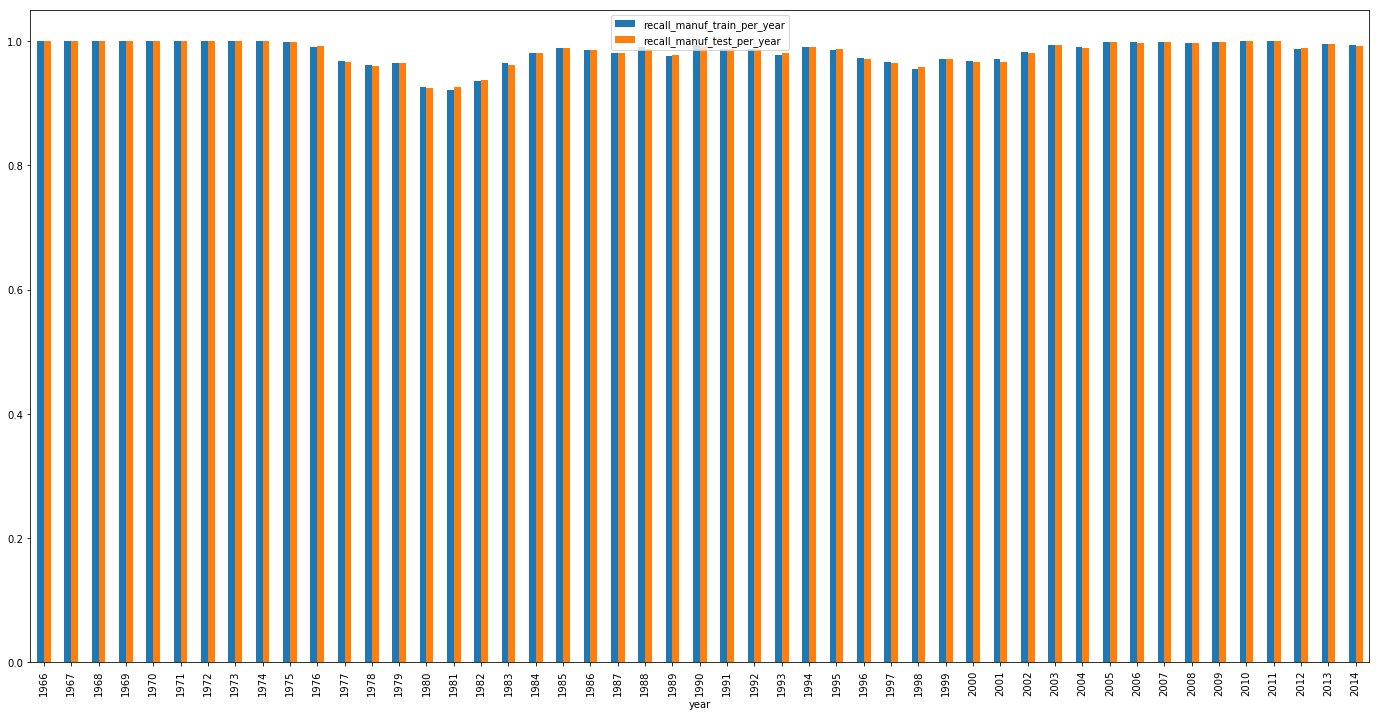

In [22]:
res_manuf_df.plot.bar(x='year',y=['recall_manuf_train_per_year','recall_manuf_test_per_year'], figsize=(24,12))

In [23]:
res_model_df = pandas.DataFrame({
'year' : list(results_model1),
'recall_model_train_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_train'][1])
    * numpy.array(results_model1[year1]['metrics_train'][3])) 
    / sum(results_model1[year1]['metrics_train'][3])  
    for year1 in results_model1.keys()],
'precision_model_train_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_train'][0])
    * numpy.array(results_model1[year1]['metrics_train'][3])) 
    / sum(results_model1[year1]['metrics_train'][3])  
    for year1 in results_model1.keys()],

'recall_model_test_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_test'][1])
    * numpy.array(results_model1[year1]['metrics_test'][3])) 
    / sum(results_model1[year1]['metrics_test'][3])  
    for year1 in results_model1.keys()],
'precision_model_test_per_year' : [
    numpy.sum(numpy.array(results_model1[year1]['metrics_test'][0])
    * numpy.array(results_model1[year1]['metrics_test'][3])) 
    / sum(results_model1[year1]['metrics_test'][3])  
    for year1 in results_model1.keys()],
})
res_model_df.sort_values(by='year', inplace=True)

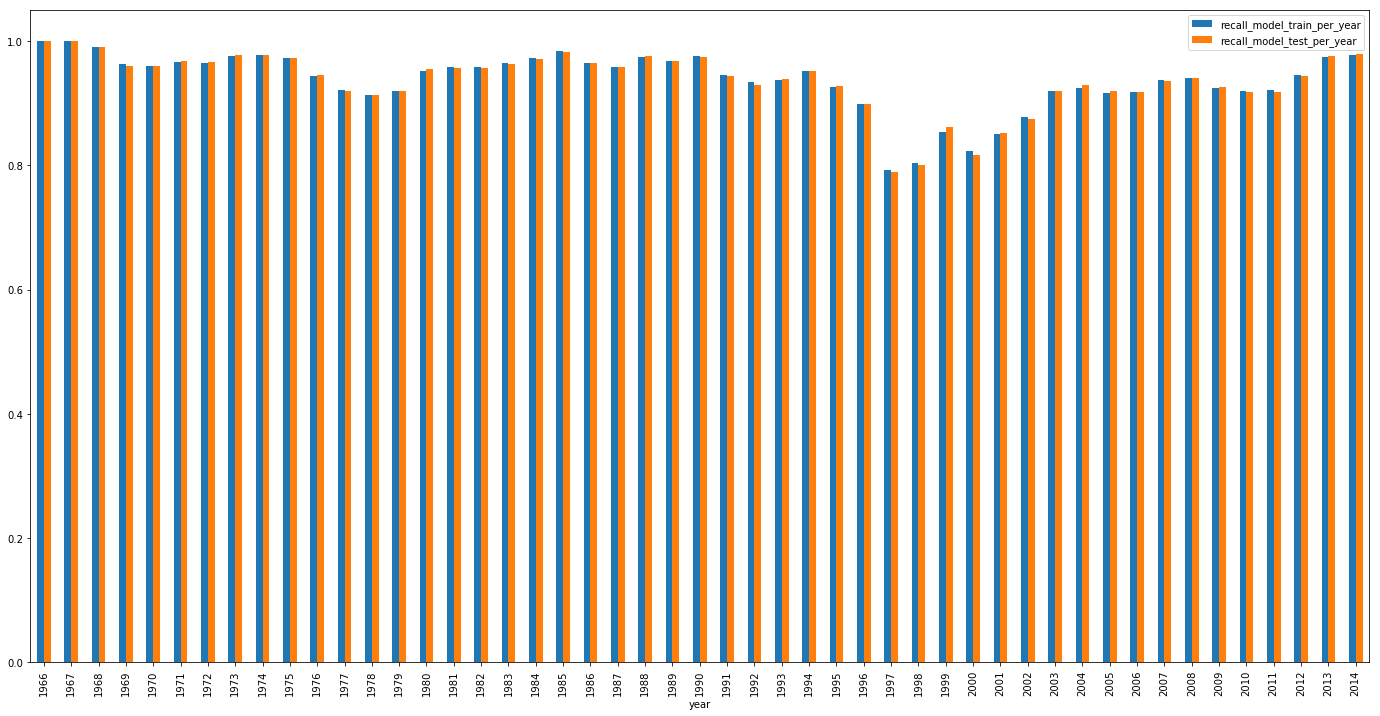

In [24]:
res_model_df.plot.bar(x='year',y=['recall_model_train_per_year','recall_model_test_per_year'], figsize=(24,12))


In [25]:
results_df = pandas.merge(res_model_df, res_manuf_df).merge(imeta_res_df)

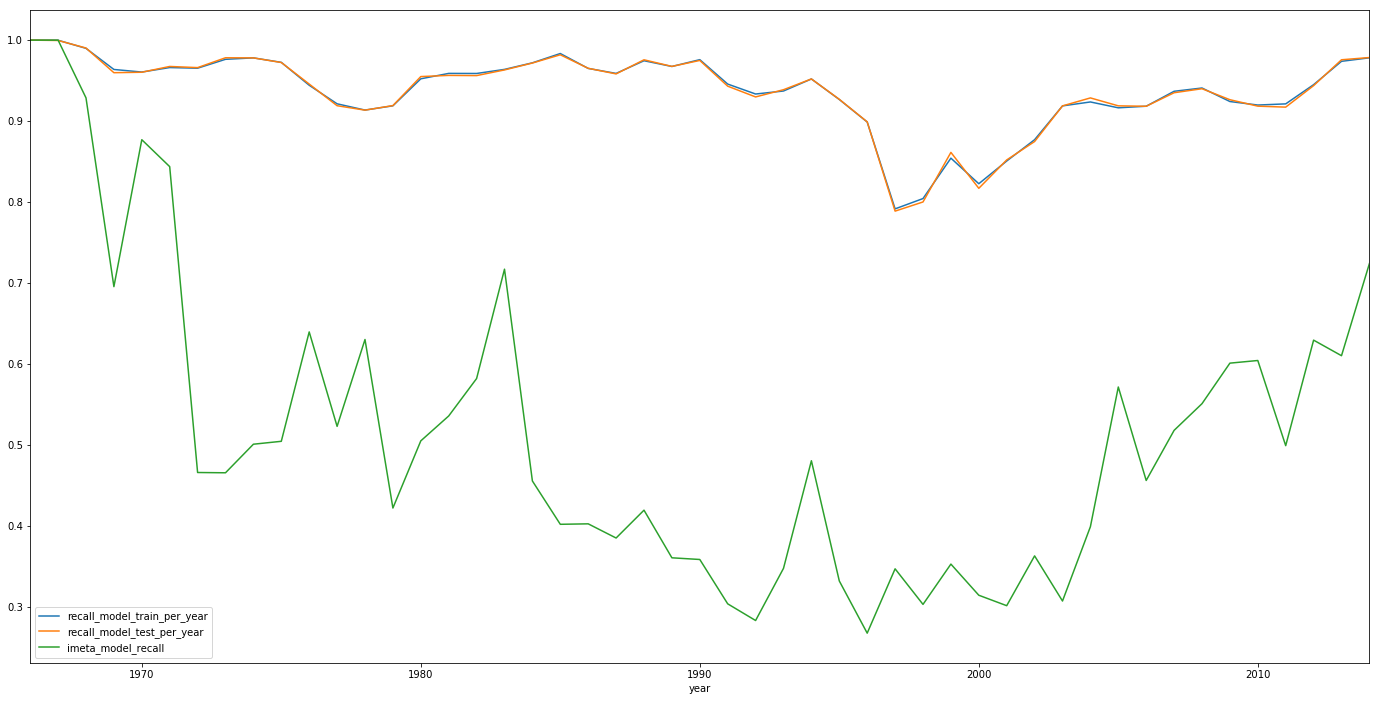

In [26]:
results_df.plot.line(x='year',y=['recall_model_train_per_year','recall_model_test_per_year', 'imeta_model_recall'], figsize=(24,12))

In [ ]:
# print(sklearn.metrics.classification_report(y_train, y_res_train))
